# Game of Thrones Character Prediction

In [1]:

! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 204kB 29.6MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 


In [3]:

#Jeff Braga
#May 30, 2021
from fastai.tabular.all import *
from fastai.text.all import *
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))



##Read in data and preprocess
df = pd.read_csv('data/got_scripts_breakdown.csv', delimiter=";", error_bad_lines=False)
df.head()

mainChars = ["jon", "jorah"]

cleanedData = pd.DataFrame(columns=["Sentence", "Character"])

for index, row in df.iterrows():
  if row["Name"] not in mainChars:
    #cleanedData.append(row["Sentence"], row["Name"])
    df = df.drop(index,axis=0)
  else:
    tempSent = row["Sentence"]
    for word in list(tempSent):  # iterating on a copy since removing will mess things up
      if (word in stop_words):
        tempSent.replace(word, "")
      row["Sentence"] = tempSent

df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
15,16,Season 1,winter is coming,Go on Father’s watching,jon,1,1,17/04/2011
16,17,Season 1,winter is coming,And your mother,jon,1,1,17/04/2011
21,22,Season 1,winter is coming,"Don’t think too much, Bran",jon,1,1,17/04/2011
37,38,Season 1,winter is coming,Don’t look away,jon,1,1,17/04/2011
39,40,Season 1,winter is coming,Father will know if you do,jon,1,1,17/04/2011
...,...,...,...,...,...,...,...,...
22351,22352,Season 7,the dragon and the wolf,Our father was more of a father,jon,67,7,27/08/2017
22353,22354,Season 7,the dragon and the wolf,And you betrayed him Betrayed his memory,jon,67,7,27/08/2017
22355,22356,Season 7,the dragon and the wolf,But you never lost him Hes a part of you Just like hes a part of me,jon,67,7,27/08/2017
22357,22358,Season 7,the dragon and the wolf,"Its not my place to forgive you for all of it But what I can forgive, I do You dont need to choose Youre a Greyjoy and youre a Stark",jon,67,7,27/08/2017


In [5]:
#Sanity Check
df.Name.unique()

array(['jon', 'jorah'], dtype=object)

In [6]:
dls_lm = TextDataLoaders.from_df(df, 
                                 text_col = 'Sentence', 
                                 label_col = 'Name', 
                                 valid_pct = 0.20, 
                                 bs = 64, 
                                 is_lm = True)




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [7]:
#See an example
dls_lm.show_batch(max_n = 1)

,text,text_
0,"xxbos xxmaj my xxunk think xxmaj i m a fool for coming here xxbos xxmaj we fight with the army we have xxbos xxmaj what are you doing ? xxbos xxmaj they xxunk the gate xxmaj get some brothers down here to help you xxmaj you need to burn the xxunk xxmaj xxunk the xxunk gate , then xxunk it again as soon as xxmaj i m out xxbos xxmaj yes ,","xxmaj my xxunk think xxmaj i m a fool for coming here xxbos xxmaj we fight with the army we have xxbos xxmaj what are you doing ? xxbos xxmaj they xxunk the gate xxmaj get some brothers down here to help you xxmaj you need to burn the xxunk xxmaj xxunk the xxunk gate , then xxunk it again as soon as xxmaj i m out xxbos xxmaj yes , he"


In [8]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult = 0.3)

In [9]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,5.053605,5.036045,00:01
1,4.918503,4.606775,00:01
2,4.686000,4.188460,00:01
3,4.452606,3.917739,00:01
4,4.246642,3.745491,00:01
5,4.075062,3.654919,00:01
6,3.927884,3.608433,00:01
7,3.811198,3.586509,00:01
8,3.715178,3.578170,00:01
9,3.636295,3.576752,00:01


In [10]:
learn.save_encoder('textpredict')

In [11]:
dls_clas = TextDataLoaders.from_df(df, 
                        valid_pct = 0.2, 
                        text_col = 'Sentence',
                        label_col = 'Name', 
                        bs = 64, 
                        text_vocab = dls_lm.vocab)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


SuggestedLRs(lr_min=0.03019951581954956, lr_steep=1.5848931980144698e-06)

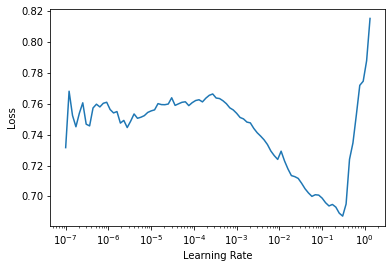

In [12]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult = 0.5, metrics = accuracy).to_fp16()
learn = learn.load_encoder('textpredict')
learn.lr_find()

In [13]:
learn.fit_one_cycle(1, 8.2e-1)
learn.freeze_to(-2)
learn.fit_one_cycle(1, 9.2e-1)
learn.freeze_to(-4)
learn.fit_one_cycle(1, 10.2e-1)
learn.unfreeze()
learn.fit_one_cycle(25, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.856151,1.035015,0.398467,00:01


epoch,train_loss,valid_loss,accuracy,time
0,5.400352,12.858128,0.249042,00:01


epoch,train_loss,valid_loss,accuracy,time
0,36.317371,40.500343,0.340996,00:02


epoch,train_loss,valid_loss,accuracy,time
0,36.735268,32.955917,0.249042,00:02
1,34.136147,24.131277,0.252874,00:02
2,28.122047,13.500073,0.283525,00:02
3,20.656063,4.420598,0.620690,00:02
4,14.960490,52.404934,0.750958,00:02
5,11.133197,nan,0.708812,00:02
6,8.454152,112.656784,0.252874,00:02
7,6.584903,2.355083,0.639847,00:02
8,5.293323,2.650908,0.747126,00:02
9,4.310366,3.334337,0.750958,00:02


In [15]:
learn.predict("north of the wall with the wildlings")

('jon', tensor(0), tensor([0.8183, 0.1817]))